In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Use only 'Close' price for simplicity
df = df[['Date', 'Close']]
df = df.rename(columns={'Close': 'close'})
df.set_index('Date', inplace=True)
df.head()


,close
Date,
2012-01-03,663.59
2012-01-04,666.45
2012-01-05,657.21
2012-01-06,648.24
2012-01-09,620.76


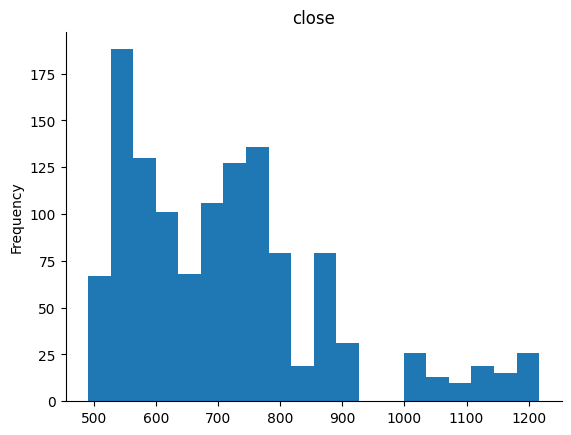

In [34]:
# @title close

from matplotlib import pyplot as plt
df['close'].plot(kind='hist', bins=20, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

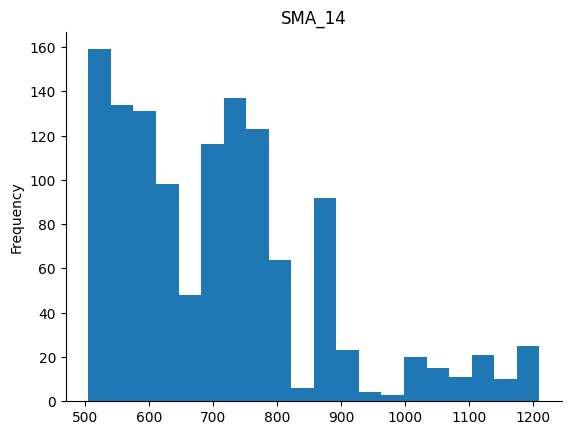

In [33]:
# @title SMA_14

from matplotlib import pyplot as plt
df['SMA_14'].plot(kind='hist', bins=20, title='SMA_14')
plt.gca().spines[['top', 'right',]].set_visible(False)

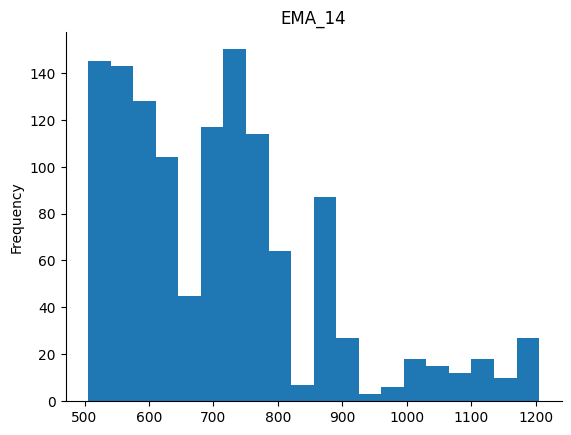

In [32]:
# @title EMA_14

from matplotlib import pyplot as plt
df['EMA_14'].plot(kind='hist', bins=20, title='EMA_14')
plt.gca().spines[['top', 'right',]].set_visible(False)

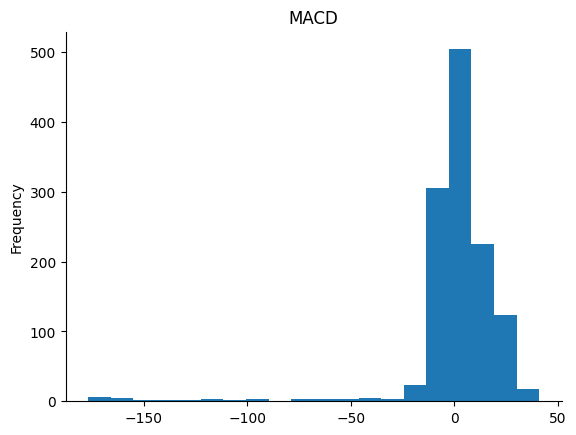

In [31]:
# @title MACD

from matplotlib import pyplot as plt
df['MACD'].plot(kind='hist', bins=20, title='MACD')
plt.gca().spines[['top', 'right',]].set_visible(False)

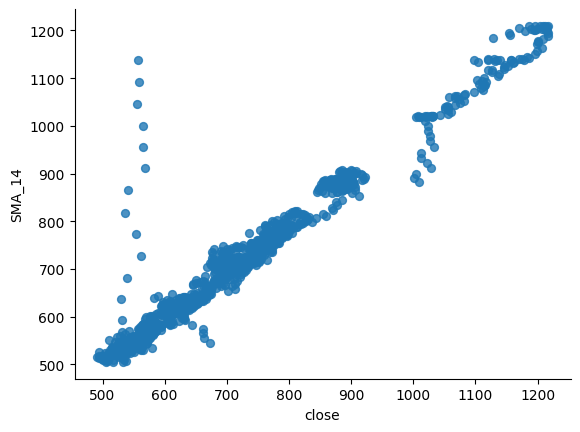

In [30]:
# @title close vs SMA_14

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='close', y='SMA_14', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

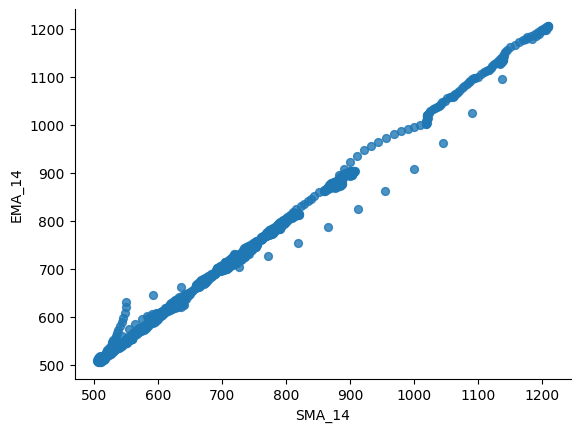

In [29]:
# @title SMA_14 vs EMA_14

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='SMA_14', y='EMA_14', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

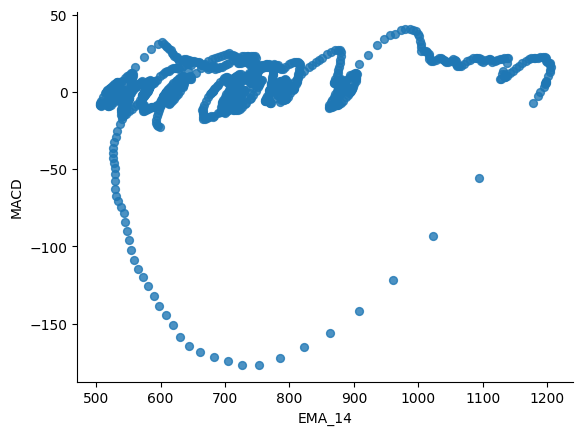

In [28]:
# @title EMA_14 vs MACD

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='EMA_14', y='MACD', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

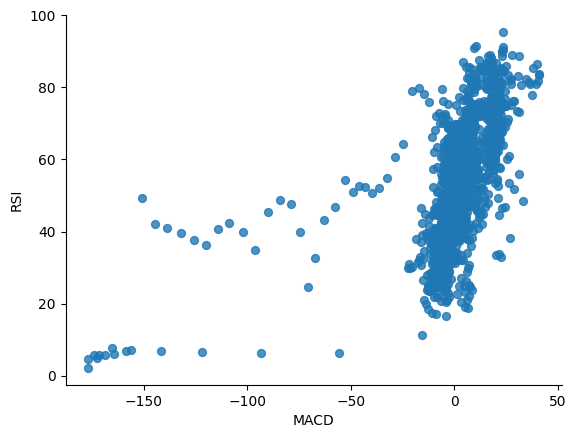

In [27]:
# @title MACD vs RSI

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='MACD', y='RSI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

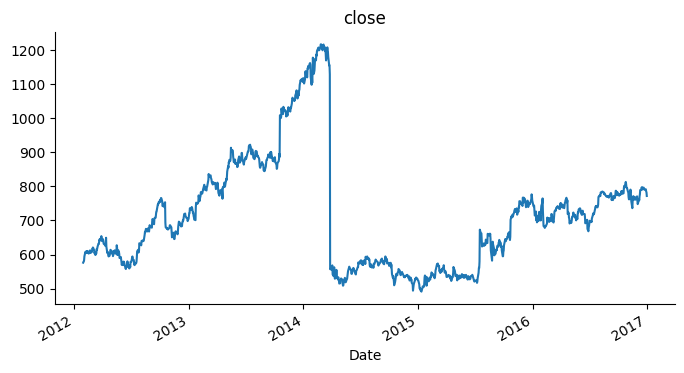

In [26]:
# @title close

from matplotlib import pyplot as plt
df['close'].plot(kind='line', figsize=(8, 4), title='close')
plt.gca().spines[['top', 'right']].set_visible(False)

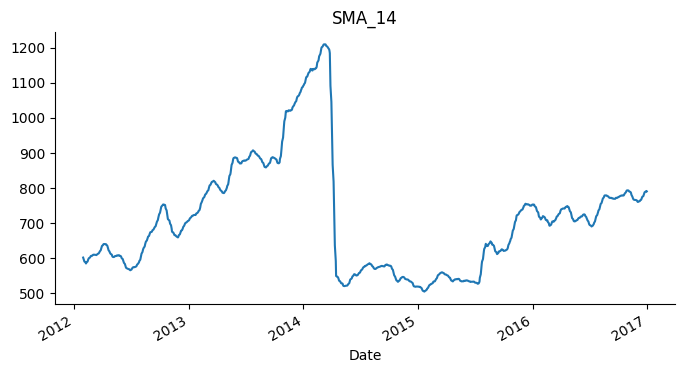

In [25]:
# @title SMA_14

from matplotlib import pyplot as plt
df['SMA_14'].plot(kind='line', figsize=(8, 4), title='SMA_14')
plt.gca().spines[['top', 'right']].set_visible(False)

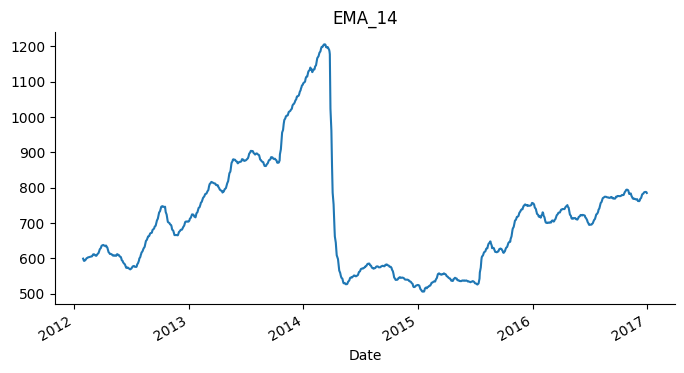

In [24]:
# @title EMA_14

from matplotlib import pyplot as plt
df['EMA_14'].plot(kind='line', figsize=(8, 4), title='EMA_14')
plt.gca().spines[['top', 'right']].set_visible(False)

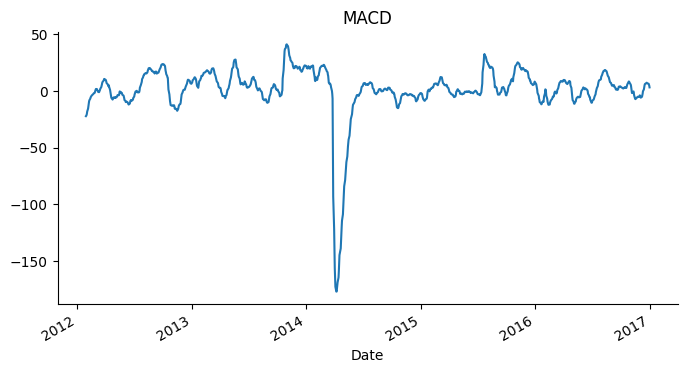

In [23]:
# @title MACD

from matplotlib import pyplot as plt
df['MACD'].plot(kind='line', figsize=(8, 4), title='MACD')
plt.gca().spines[['top', 'right']].set_visible(False)

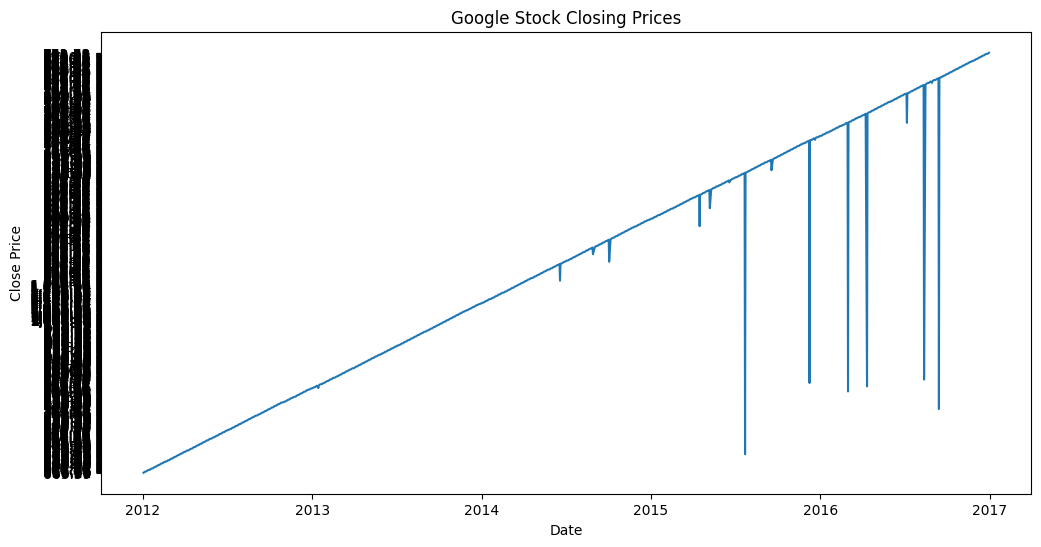

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df['close'])
plt.title('Google Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [7]:
# Convert 'close' to numeric, handling commas
df['close'] = df['close'].astype(str).str.replace(',', '', regex=False)
df['close'] = pd.to_numeric(df['close'])

# Simple Moving Average
df['SMA_14'] = df['close'].rolling(window=14).mean()

# Exponential Moving Average
df['EMA_14'] = df['close'].ewm(span=14, adjust=False).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [8]:
df = df.dropna()


In [9]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [10]:
# ARIMA expects a 1D array
arima_train = train['close']
arima_test = test['close']

# Fit ARIMA (order can be tuned)
model = ARIMA(arima_train, order=(5,1,0))
model_fit = model.fit()
arima_pred = model_fit.forecast(steps=len(arima_test))

# Evaluation
print('ARIMA RMSE:', np.sqrt(mean_squared_error(arima_test, arima_pred)))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 34.594894649599865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
# Create lag features
for lag in range(1, 6):
    df[f'lag_{lag}'] = df['close'].shift(lag)

df = df.dropna()

features = ['SMA_14', 'EMA_14', 'MACD', 'RSI'] + [f'lag_{i}' for i in range(1,6)]
X = df[features]
y = df['close']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))


XGBoost RMSE: 9.817055317193104


In [13]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['close']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_lstm, y_lstm = create_sequences(scaled_close, seq_length)

X_lstm_train = X_lstm[:train_size-seq_length]
y_lstm_train = y_lstm[:train_size-seq_length]
X_lstm_test = X_lstm[train_size-seq_length:]
y_lstm_test = y_lstm[train_size-seq_length:]

X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))


In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0504 - val_loss: 0.0014
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0134 - val_loss: 0.0014
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0068 - val_loss: 8.6319e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0074 - val_loss: 9.6121e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0084 - val_loss: 7.9326e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0057 - val_loss: 7.8586e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0042 - val_loss: 6.2787e-04
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0041 - val_loss: 6.4978e-04
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0030 - val_loss: 5.9810e-04
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━

In [15]:
lstm_pred = model.predict(X_lstm_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_lstm_test_inv = scaler.inverse_transform(y_lstm_test.reshape(-1,1))

print('LSTM RMSE:', np.sqrt(mean_squared_error(y_lstm_test_inv, lstm_pred)))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
LSTM RMSE: 14.698284614599096


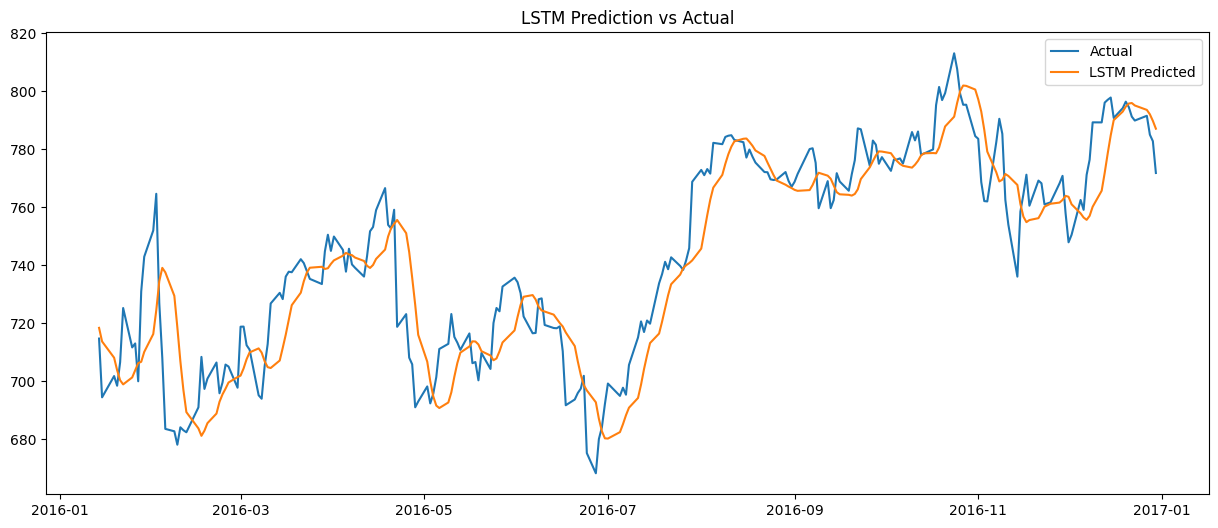

In [16]:
plt.figure(figsize=(15,6))
plt.plot(df.index[-len(y_lstm_test):], y_lstm_test_inv, label='Actual')
plt.plot(df.index[-len(y_lstm_test):], lstm_pred, label='LSTM Predicted')
plt.legend()
plt.title('LSTM Prediction vs Actual')
plt.show()


In [17]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'XGBoost', 'LSTM'],
    'RMSE': [
        np.sqrt(mean_squared_error(arima_test, arima_pred)),
        np.sqrt(mean_squared_error(y_test, xgb_pred)),
        np.sqrt(mean_squared_error(y_lstm_test_inv, lstm_pred))
    ]
})
print(results)


     Model       RMSE
0    ARIMA  34.594895
1  XGBoost   9.817055
2     LSTM  14.698285


In [41]:
# Get the date index for the last 244 days of the test set
prediction_dates = test.index[-len(y_lstm_test_inv):]

# Create a DataFrame with actual values and predictions, aligned by date
predictions_df = pd.DataFrame({
    'Date': prediction_dates,
    'Actual_Close': test.loc[prediction_dates, 'close'],
    'ARIMA_Prediction': arima_pred[-len(y_lstm_test_inv):].values, # Access by position, not index
    'XGBoost_Prediction': xgb_pred,
    'LSTM_Prediction': lstm_pred.flatten()
})

In [44]:
predictions_df.to_csv('predictions.csv', index=False)